# Modélisation

### Random Forest

Après avoir bien fouillé les données, la Random Forest (Forêt Aléatoire) s'impose comme le meilleur outil pour ce dataset pour plusieurs raisons super concrètes. D'abord, c'est un modèle "tout-terrain" : il se moque de savoir si tes variables sont des chiffres ou du texte (une fois encodées) et il gère très bien le mélange des deux sans qu'on ait besoin de tout normaliser.
Ensuite, nos graphiques ont montré que les relations sont loin d'être simples. Par exemple, le salaire ne monte pas de façon régulière avec l'âge ; il y a des effets de paliers et des interactions bizarres entre le genre, le métier et les diplômes. La Random Forest adore ça : elle va créer plein de petits arbres de décision qui vont capturer ces scénarios précis (ex: "si tu as tel diplôme ET que tu es dans tel métier, alors tu as 80% de chances de gagner plus de 50k").
Enfin, c'est un modèle très solide face aux valeurs bizarres (les fameux outliers qu'on a vus sur l'âge ou les gains en capital) et il nous permet de tricher un peu pour compenser le fait qu'il y a beaucoup moins de "riches" que de "pauvres" dans nos données en utilisant l'option class_weight='balanced'. En bonus, il pourra nous dire après coup quelles variables ont été les plus utiles pour ses prédictions !

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

--- Rapport de Performance ---
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4976
           1       0.72      0.60      0.65      1537

    accuracy                           0.85      6513
   macro avg       0.80      0.76      0.78      6513
weighted avg       0.84      0.85      0.84      6513



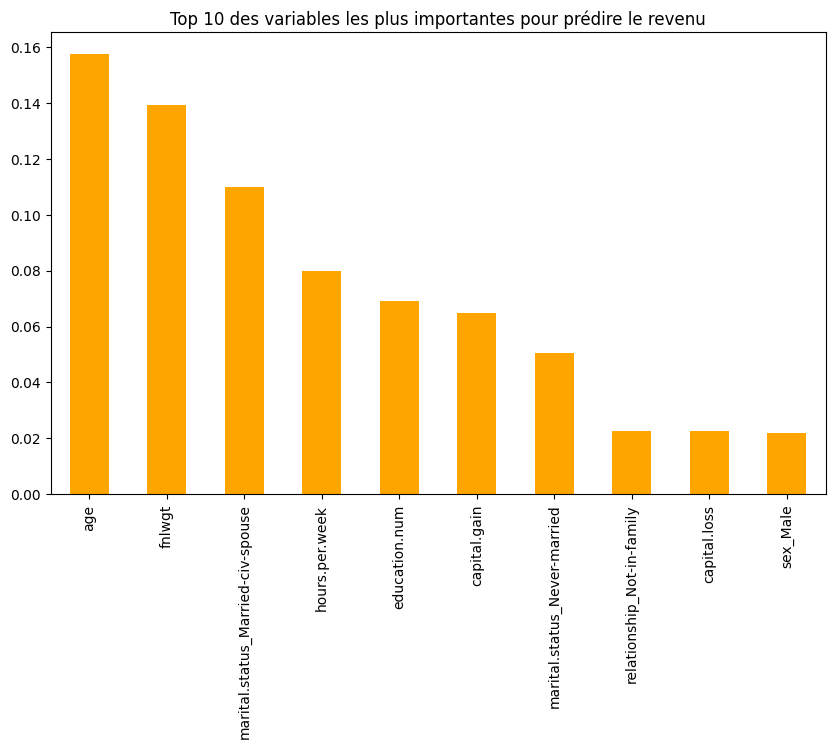

In [2]:
df = pd.read_csv('../data/processed/adult_cleaned.csv')
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

# On transforme toutes les variables catégorielles (texte) en chiffres (One-Hot Encoding)
df_encoded = pd.get_dummies(df, drop_first=True)

# On sépare les caractéristiques (X) de la cible à prédire (y)
X = df_encoded.drop('income', axis=1)
y = df_encoded['income']

# 2. Split Train/Test
# On garde 20% des données pour tester si le modèle est vraiment bon
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Création et entraînement du modèle
# On utilise 'balanced' pour ne pas ignorer les "riches" qui sont moins nombreux
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# 4. Évaluation
y_pred = rf_model.predict(X_test)

print("--- Rapport de Performance ---")
print(classification_report(y_test, y_pred))

# 5. Visualisation de l'importance des variables
# On regarde ce qui a le plus aidé le modèle à décider
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
importances.plot(kind='bar', color='orange')
plt.title('Top 10 des variables les plus importantes pour prédire le revenu')
plt.show()

## Explication des modèles (obligatoire) Fournir des explications sur :
#### Ce qu’est chaque modèle, avec vos propres mots 
Imagine que pour prédire le salaire d'une personne, au lieu de demander l'avis d'un seul expert, tu réunisses une assemblée de 100 conseillers. Chaque conseiller (un "arbre de décision") va regarder un échantillon différent des données et se spécialiser sur certains critères, comme le niveau d'étude ou l'âge. À la fin, ils votent tous : si la majorité des arbres dit que la personne gagne plus de 50k, c'est ce que le modèle choisira. C'est ce qu'on appelle un modèle d'ensemble, car il combine la sagesse de plusieurs "petits" modèles pour être beaucoup plus précis et stable qu'un seul.

#### Pourquoi vous l’avez choisi
Le choix de la Random Forest est particulièrement pertinent pour le dataset Adult Census Income car il gère nativement le mélange de données textuelles et numériques que nous avons nettoyées. Contrairement à d'autres modèles, il n'a pas besoin que les données soient parfaitement normalisées et il est très robuste face aux valeurs aberrantes (outliers), comme les âges très élevés ou les gains en capital extrêmes que nous avons observés dans l'analyse univariée. De plus, il excelle à capturer les interactions complexes : par exemple, il comprendra facilement que l'impact de l'âge sur le revenu n'est pas le même selon que l'on est marié ou non, ce qui correspond bien à nos graphiques bivariés.

#### Les variables les plus importantes (importance des features / coefficients)
l'algorithme a identifié trois piliers majeurs pour prédire le revenu. En tête, on retrouve l'âge, ce qui confirme que l'expérience accumulée au fil des années reste le premier facteur de hausse de salaire dans ce dataset. Juste après vient le fnlwgt (le poids démographique), suivi de très près par le statut marital (Married-civ-spouse). C'est un point clé : le modèle a détecté que le fait d'être marié est un indicateur social extrêmement fort pour appartenir à la tranche des hauts revenus, validant ainsi nos observations lors de l'analyse de la cible. On note aussi que le niveau d'éducation numérique (education.num) reste dans le top 5, prouvant que le diplôme est une barrière à l'entrée concrète.

#### L’analyse d’erreurs (où le modèle échoue, quels groupes/régions/segments)
on voit que le modèle a un "score F1" de 0.90 pour les bas revenus, mais qu'il chute à 0.65 pour les revenus >50K. Cela signifie qu'il a du mal à identifier précisément les personnes riches. Plus précisément, son "recall" de 0.60 indique qu'il rate 40% des personnes gagnant plus de 50k, en les classant par erreur dans la catégorie inférieure. Ce type d'erreur arrive souvent sur des segments atypiques, comme des profils très jeunes avec de hauts revenus ou des personnes très diplômées qui travaillent dans des secteurs moins rémunérateurs. Le déséquilibre des classes (75% vs 25%) reste le défi majeur : le modèle a eu beaucoup plus d'exemples pour apprendre à reconnaître un "bas revenu" qu'un "haut revenu".